In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [12]:
df = pd.read_csv("car data.csv")  
df.head()


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [16]:
print(df.shape)
print(df.columns)
df.info()


(301, 9)
Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms',
       'Fuel_Type', 'Selling_type', 'Transmission', 'Owner'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [19]:
# After loading dataset
df = pd.read_csv("car data.csv")

# Convert all column names to lowercase for consistency
df.columns = df.columns.str.lower()

# Check column names
print(df.columns)


Index(['car_name', 'year', 'selling_price', 'present_price', 'driven_kms',
       'fuel_type', 'selling_type', 'transmission', 'owner'],
      dtype='object')


In [21]:
# Clean numeric columns safely
for col in ['mileage', 'engine', 'max_power']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(' kmpl', '', regex=False)\
                                   .str.replace(' km/kg', '', regex=False)\
                                   .str.replace(' CC', '', regex=False)\
                                   .str.replace(' bhp', '', regex=False)

# Convert to numeric (ignore errors)
for col in ['mileage', 'engine', 'max_power']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("Unknown", inplace=True)

df.head()


,car_name,year,selling_price,present_price,driven_kms,fuel_type,selling_type,transmission,owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [25]:
# Create a car age feature
df["car_age"] = 2025 - df["year"]

# Log transform the target for better scaling
df["log_selling_price"] = np.log1p(df["selling_price"])


In [27]:
# Define features and target variable safely
columns_to_drop = ["selling_price", "log_selling_price", "name", "torque"]

# Drop only columns that actually exist in the DataFrame
X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Target variable
y = df["log_selling_price"]

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((240, 9), (61, 9))

In [30]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

num_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])


In [32]:
model = RandomForestRegressor(random_state=42, n_estimators=200)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'present_price',
                                                   'driven_kms', 'owner',
                                                   'car_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['car_name', 'fuel_type',
                                                   'selling_type',
                                                   'transmission'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [34]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")


Model Evaluation:
MAE : 0.093
RMSE: 0.128
R²  : 0.973


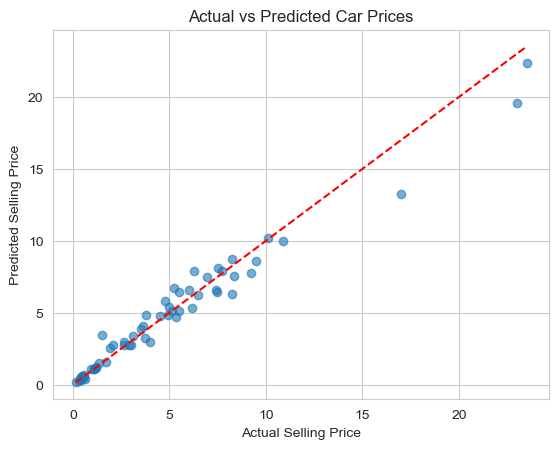

In [36]:
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

plt.scatter(y_test_real, y_pred_real, alpha=0.6)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Car Prices")
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.show()


In [37]:
import joblib
joblib.dump(pipeline, "car_price_predictor.pkl")
print("✅ Model saved successfully!")


✅ Model saved successfully!
